# Description:

Tests on the non-unitary operations introduced through an ancilla using the method propposed by Lin et al. (2021) in their Appendix D. 

In [10]:
import numpy as np
from scipy.linalg import svd, qr

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.circuit.library import UnitaryGate

from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


def kronecker_product(matrices):
    """Compute the Kronecker product of a list of matrices."""
    result = np.eye(1)
    for matrix in matrices:
        result = np.kron(result, matrix)
    return result

def large_matrix(matrix, index, num_qubits):
    """Compute the 2^n x 2^n matrix from the 2x2 matrix acting on 
    the ith qubit."""
    I = np.eye(2)
    operators = [I]*num_qubits
    operators[index] = matrix
    return operators

def insert_non_unitary(matrix):
    """
    Returns a 2^n+1 x 2^n+1 matrix that transforms the 
    non-unitary operation into a unitary operation
    Input:
        matrix: 2^n x 2^n matrix
    Output:
        2^n+1 x 2^n+1 unitary matrix
    """
    # Step 1: Compute SVD of CU
    U_, Sigma, Vh = svd(matrix)

    # Step 2: Find scaling factor s (largest eigenvalue of CU†CU)
    s2 = np.max(Sigma**2) # sigma contains the square root of the eigenvalues of CU†CU
    s = 1 / np.sqrt(s2)

    # Step 3: Construct C from Sigma
    Sigma_tilde = np.sqrt(np.maximum(0, 1 - s**2 * Sigma**2))
    # We take the maximum because all the values should be non-negative
    # and rounding might lead to negative values
    C = U_ @ np.diag(Sigma_tilde) @ Vh

    # Step 4: Create a random B and D for the unitary block
    B_tilde = np.random.rand(matrix.shape[0], matrix.shape[0])
    D_tilde = np.random.rand(matrix.shape[0], matrix.shape[0])

    # Step 5: Construct ŨA and apply QR decomposition
    U_tilde = np.block([[s * matrix, B_tilde], [C, D_tilde]])
    UA, _ = qr(U_tilde)  # Final Unitary Operator

    return UA

def quantum_circuit(num_qubits, non_unitary_operator, *states, measure_all = False):
    """
    Creates a quantum circuit that apples the non-unitary operator
    by adding one ancilla

    Input:
        num_qubits: number of qubits in the circuit
        non_unitary_operator: 2^n x 2^n matrix
        states*: a list with the states to be initialized in the main qubits
        measure_all: if True, measure all qubits (including ancilla), else measure only main qubits
    Output:
        quantum_circuit: a quantum circuit applying the non-unitary operator
    """
    main_qubits = QuantumRegister(num_qubits, 'main')
    ancilla_qubits = QuantumRegister(1, 'ancilla')

    main_clbits = ClassicalRegister(num_qubits, 'main_cl')
    ancilla_clbits = ClassicalRegister(1, 'ancilla_cl')

    qc = QuantumCircuit(main_qubits, ancilla_qubits, main_clbits, ancilla_clbits)

    for i,state in enumerate(states):
        qc.initialize(state, i)


    operator = insert_non_unitary(non_unitary_operator)
    gate = UnitaryGate(operator)

    qc.append(gate, list(range(num_qubits+1)))
    
    if measure_all:
        qc.measure_all()
    else:
        qc.measure(list(range(num_qubits)), main_clbits)

    return qc

def simulate_qc(qc):
    # Step 1: Set up simulator (BackendV2 workflow)
    simulator = Aer.get_backend('aer_simulator')

    # Step 2: Transpile and run the circuit using updated method
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit).result()

    # Step 3: Get and visualize results
    counts = result.get_counts()

    return counts

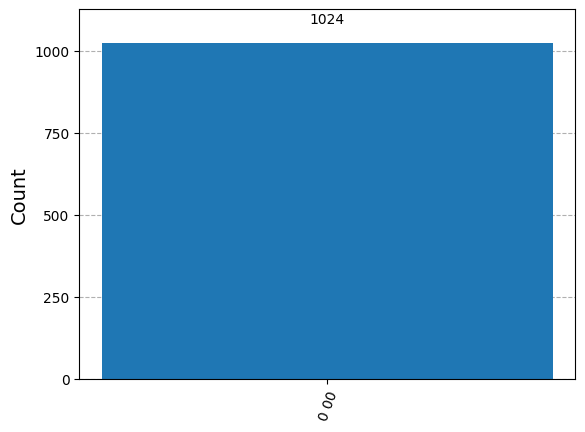

In [11]:
# Example usage:

# In a system of 2 qubits, the identity operation
# works as intended (does not do anything)

num_qubits = 2
op = np.eye(4)
qc = quantum_circuit(num_qubits,op)
counts = simulate_qc(qc)

plot_histogram(counts)

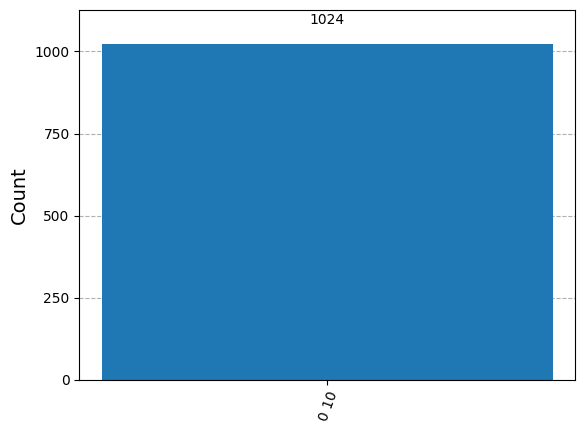

In [12]:
# In inverting the state of qubit 0, it works well
num_qubits = 2
op = np.array([[0,0,1,0],
              [0,0,0,1],
              [1,0,0,0],
              [0,1,0,0]])
qc = quantum_circuit(num_qubits,op)
counts = simulate_qc(qc)

plot_histogram(counts)

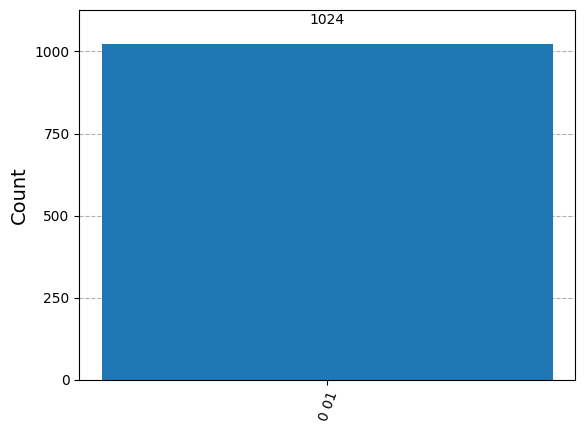

In [13]:
# In inverting the state of qubit 0, it works well
num_qubits = 2
op1 = np.eye(2) # identity to the first
op2 = np.array([[0,1],
              [1,0]]) # inverting the second
op = kronecker_product([op1,op2])
qc = quantum_circuit(num_qubits,op)
counts = simulate_qc(qc)

plot_histogram(counts)

The following code cells test the non-unitary operation

\begin{align*}
    U = \begin{bmatrix} \sqrt {1-a} && 0 \\ \sqrt{a} && 1\end{bmatrix}
\end{align*}

And their controlled form

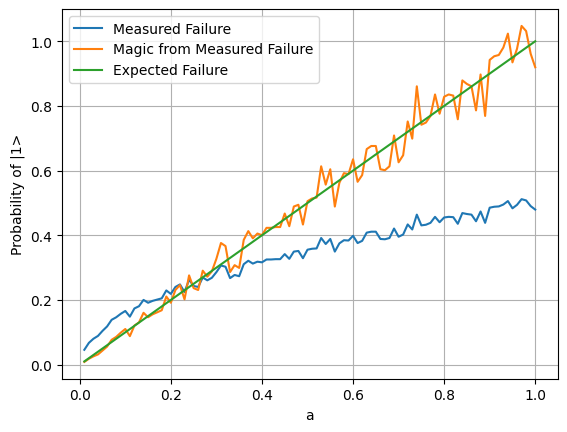

In [14]:
# In setting the operation in qubit 0 as 
# U|0> = sqrt(1-a) |0> + sqrt(a) |1>
# U|1> = |1>

num_qubits = 2

a_values = np.linspace(0.01,1, 100)
measured_failure = np.zeros(len(a_values))

for index,a in enumerate(a_values):

    op = np.array([[np.sqrt(1-a),0,0,0],
                [np.sqrt(a),1,0,0],
                [0,0,1,0],
                [0,0,0,1]])
    qc = quantum_circuit(num_qubits,op)
    counts = simulate_qc(qc)
    measured_failure[index] = counts['0 01'] / 1024

plt.plot(a_values, measured_failure, label = 'Measured Failure')
plt.plot(a_values, measured_failure**2 * 4, label = 'Magic from Measured Failure')
# I don't think this is actually relevant, and I just fitted with my eye
plt.plot(a_values, a_values, label = 'Expected Failure')
plt.xlabel('a')
plt.ylabel("Probability of |1>")
plt.legend()
plt.grid(True)
plt.show();


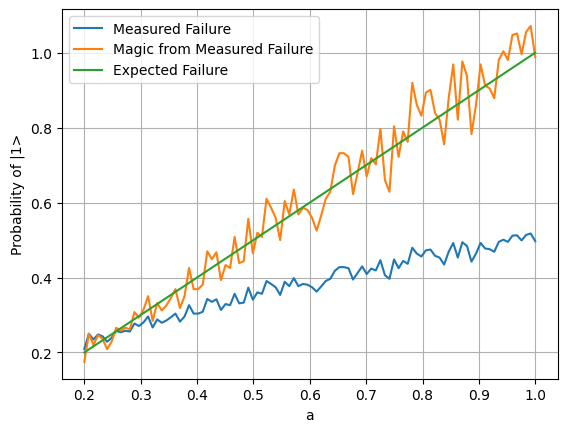

In [15]:
# In setting the controlled operation in qubit 0
# with a control on qubit 1

num_qubits = 2

a_values = np.linspace(0.2,1, 100)
measured_failure = np.zeros(len(a_values))

for index,a in enumerate(a_values):

    # Step 1: Define identity and U_ij operators
    I = np.eye(2)
    U = np.array([[np.sqrt(1 - a), 0], 
                    [np.sqrt(a), 1]])

    # Step 2: Construct the controlled operator in 2^n x 2^n form
    target = 1
    control = 0
    # THE CONTROL AND THE TARGET ARE INVERTED FOR SOME REASON???

    # Create list of operators for Kronecker product
    operators = [I] * (num_qubits)
    operators[control] = np.array([[1, 0], [0, 0]])  # |0⟩⟨0|
    CU_0 = kronecker_product(operators)  # First part: applies identity if control is |0⟩

    operators = [I] * (num_qubits) 
    operators[control] = np.array([[0, 0], [0, 1]])  # |1⟩⟨1|
    operators[target] = U
    CU_1 = kronecker_product(operators)  # Second part: applies U if control is |1⟩

    CU = CU_0 + CU_1
 
    qc = quantum_circuit(num_qubits,CU, [1,0],[0,1])
    counts = simulate_qc(qc)

    try: 
        measured_failure[index] = counts['0 11'] / 1024
    except:      
        measured_failure[index] = 0 
#qc.draw("mpl")
plt.plot(a_values, measured_failure, label = 'Measured Failure')
plt.plot(a_values, measured_failure**2 * 4, label = 'Magic from Measured Failure')
# I don't think this is actually relevant, and I just fitted with my eye
# This is probably because the operation is exactly the same as in before
plt.plot(a_values, a_values, label = 'Expected Failure')
plt.xlabel('a')
plt.ylabel("Probability of |1>")
plt.legend()
plt.grid(True)
plt.show();


# References:

Lin, S., Dilip, R., Green, A. G., Smith, A., & Pollmann, F. (2021). Real- and Imaginary-Time Evolution with Compressed Quantum Circuits. PRX Quantum, 2(1). https://doi.org/10.1103/prxquantum.2.010342